This code is for selecting the best classification models based on K-fold cross-validation

In [16]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
plt.style.use('seaborn')


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

from sklearn.neural_network import MLPClassifier

from sklearn import model_selection


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Load data

In [29]:
# Read data from stata file
df=pd.read_stata('./data/company_mlf.dta')
print(df.shape)
df.head()

(2485, 99)


,company_id,year,inno_Y,innovation_index,company_type,company_location,company_size,company_age,registdate,registcapital,...,fxi_tekimprove,rnd,industry_investment,tekimprove_investment,training_investment,maxemployee,industry_lvl1,industry_lvl2,industry_lvl3,industry_lvl4
0,433116,2014,0,31.679552,4.0,3.0,2.0,1.0,2013-06-14,225.0,...,0.0,328.17,0.0,0.0,0.0,29,信息传输、软件和信息技术服务业,软件和信息技术服务业,软件开发,软件开发
1,485631,2014,0,63.777325,4.0,6.0,4.0,16.0,1998-06-05,31215.6,...,NaN,336.50,NaN,NaN,NaN,713,,,,
2,485673,2014,0,31.679552,2.0,2.0,2.0,11.0,2003-09-05,1000.0,...,NaN,239.71,NaN,NaN,NaN,80,信息传输、软件和信息技术服务业,软件和信息技术服务业,软件开发,软件开发
3,485760,2014,0,40.536419,4.0,6.0,4.0,16.0,1998-06-09,16000.0,...,10084.0,13749.00,53060.0,10084.0,98.1,1660,制造业,其他制造业,其他未列明制造业,其他未列明制造业
4,485913,2014,1,29.921761,2.0,4.0,2.0,14.0,2000-10-18,600.0,...,100.0,331.76,0.0,0.0,9.6,180,制造业,化学原料和化学制品制造业,专用化学产品制造,化学试剂和助剂制造


# Preprocessing

In [6]:
from sklearn.model_selection import train_test_split

data = df.values
X = data[:,2:]
y = data[:,1]
X = X.astype(str)
y = y.reshape(len(y),1)
print(X.shape,y.shape)

# Split training and testing data 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=1234,
                                                    stratify=y)
print('Train: ', train_X.shape,train_y.shape)
print('Test:', test_X.shape,test_y.shape)

(2485, 256) (2485, 1)
Train:  (2236, 256) (2236, 1)
Test: (249, 256) (249, 1)


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

def prepare_inputs(X_train,X_test):
    oe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)

    return X_train_enc, X_test_enc

def prepare_target(y_train,y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc=le.transform(y_train)
    y_test_enc=le.transform(y_test) 
    
    return y_train_enc, y_test_enc

X_train, X_test = prepare_inputs(train_X,test_X)
y_train, y_test = prepare_target(train_y,test_y)
X_test

array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.]])

In [8]:
import numpy as np 

print(pd.DataFrame(y_train)[0].value_counts())
print(pd.DataFrame(y_test)[0].value_counts())

1    1720
0     516
Name: 0, dtype: int64
1    192
0     57
Name: 0, dtype: int64


# Results 

Testing results based on K-fold Cross validation

In [10]:
from sklearn.model_selection import KFold

models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('Linear-Ridge',linear_model.RidgeClassifier()))


models.append(('GausNB', GaussianNB()))
models.append(('BernNB', BernoulliNB()))

models.append(('KNN-k', KNeighborsClassifier()))

models.append(('SVM-SVC',svm.SVC()))
models.append(('SVM-LinearSVC',svm.LinearSVC()))

models.append(('RForest', RandomForestClassifier(n_jobs=-1)))
models.append(('GBST', xgb.XGBClassifier(nthread=-1)))

names = []
F1_score = []
roc_score = []
Precision = []
Recall = []

for name, clf in models:    
    print(name)      
        
    kf = KFold(n_splits=5)
   
    for train_i, test_i in kf.split(X_train,y_train):
        X_train_val,y_train_val=X_train[train_i],y_train[train_i]
        X_test_val, y_test_val = X_train[test_i], y_train[test_i]
        
        clf.fit(X_train_val,y_train_val)
    
        y_pred_test= clf.predict(X_test_val)
    
        confusion = confusion_matrix(y_test_val, y_pred_test)        
        roc = roc_auc_score(y_test_val, y_pred_test)*100
        
        F1 =  f1_score(y_test_val, y_pred_test,average='weighted')*100
        precision = precision_score(y_test_val.ravel(), y_pred_test)*100
        recall = recall_score(y_test_val.ravel(), y_pred_test)*100        
    
        names.append(name)  
        Precision.append(precision)
        Recall.append(recall)
        roc_score.append(roc)
        F1_score.append(F1)

# Summarize all result         
dfx = pd.DataFrame({'classifier':names,'ROC':roc_score, 'F1':F1_score,
                  'precision':Precision,'recall':Recall})
dfx = df[['classifier','F1','ROC','precision','recall']]
# Save results 
dfx.to_excel('../result/model_result.xlsx',encoding='utf-8')
dfx.groupby(['classifier']).mean()

LR
LDA
QDA
Linear-Ridge
GausNB
BernNB
KNN-k
SVM-SVC
SVM-LinearSVC
RForest
GBST


,F1,ROC,precision,recall
classifier,,,,
BernNB,67.115732,50.204273,76.994560,100.000000
GBST,97.944894,97.175067,98.717523,98.607999
GausNB,79.266543,64.212732,82.366663,98.789801
KNN-k,86.693198,86.279546,95.533435,85.882457
LDA,68.180887,51.709964,77.640626,89.303901
LR,97.355025,96.110928,98.152529,98.435995
Linear-Ridge,97.022175,95.095638,97.417747,98.786451
QDA,79.683363,69.542303,85.849105,89.683617
RForest,91.295977,83.468860,91.161333,98.960619


# Visualization

Text(0.5, 1.0, 'F1 Score')

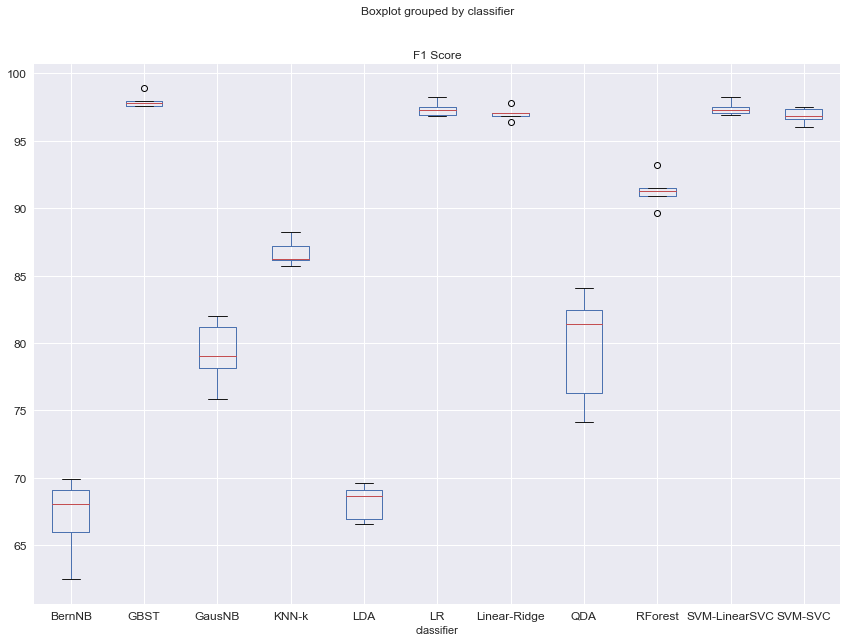

In [26]:
ax = dfx.boxplot(column='F1',by='classifier',figsize=(14,10),fontsize=12)
ax.set_title('F1 Score')